In [96]:
import random
random.seed(42)

import numpy as np
np.random.seed(42)


data_shape = 256


In [97]:

from PIL import Image
from IPython.display import display
import numpy as np
import cv2

# origin: buildings with height
# building: buildings without height
# target: the ground truth
# source: the antenna

root_origin = '../RadioMap3DSeer/png/buildingsWHeight/'
root_building = '../RadioMap3DSeer/png/buildings_complete/'
root_target = '../RadioMap3DSeer/gain/'
root_source = '../RadioMap3DSeer/png/antennasWHeight/'

root_pre = '../RadioMap3DSeer/pre/'


def get_origin_data(pic_id, idx):
    img_origin = Image.open(root_origin+str(pic_id)+'.png')
    img_building = Image.open(root_building+str(pic_id)+'.png')
    img_target = Image.open(root_target+str(pic_id)+'_'+str(idx)+'.png')
    img_source = Image.open(root_source+str(pic_id)+'_'+str(idx)+'.png')

    origin_data = np.array(img_origin)
    building_data = np.array(img_building)
    target_data = np.array(img_target)
    source_data = np.array(img_source)

    source = source_data.nonzero()
    source = list(zip(*source))
    source = source[0]

    return origin_data, building_data, target_data, source


In [98]:
import torch
def Load_Data(pic_id, idx):
    data = torch.load(root_pre+str(pic_id)+'_'+str(idx)+'.pt')
    return data

In [99]:
pic_id = 1 
idx = 0
data = Load_Data(pic_id, idx)
print(data)

Data(edge_index=[2, 134508], y=[47015], mid=[47015, 2], length=[47015], angle=[47015], height=[47015], type=[47015], is_air=[47015], edge_type=[134508], dist=[134508], num_nodes=47015, x=[47015, 6], edge_attr=[134508, 2])


In [100]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GATConv


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(42)
        self.input_layer = Linear(data.x.shape[1], hidden_channels)
        self.conv1 = GATConv(hidden_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.conv4 = GATConv(hidden_channels, hidden_channels)
        self.linear = Linear(hidden_channels, 1)


    def forward(self, x, edge_index, edge_attr):

        x = self.input_layer(x)
        
        out = self.conv1(x, edge_index, edge_attr)
        out = F.tanh(out)
        # out = F.dropout(out, training=self.training)

        out = self.conv2(out, edge_index, edge_attr)
        out = F.relu(out)
        # out = F.dropout(out, training=self.training)

        out = self.conv3(out, edge_index, edge_attr)
        out = F.tanh(out)
        # out = F.dropout(out, training=self.training)

        out = self.conv4(out, edge_index, edge_attr)
        out = F.relu(out)
        # out = F.dropout(out, training=self.training)

        out = self.linear(out) * 128

        return out.view(-1)
        # return F.softmax(out, dim=1)
    

In [101]:

model = GNN(hidden_channels=64)

print(model)

device = torch.device('cpu')
print(f'Device: {device}')
data = data.to(device)
model = model.to(device)


# optimizer and criterion

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = torch.nn.MSELoss()


GNN(
  (input_layer): Linear(in_features=6, out_features=64, bias=True)
  (conv1): GATConv(64, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (conv4): GATConv(64, 64, heads=1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
Device: cpu


In [102]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    out_air = out[data.is_air]
    y_air = data.y[data.is_air]
    # loss = torch.sqrt((out-data.y)**2+0.1)
    loss = torch.sqrt((out_air-y_air)**2+0.1)
    loss = loss.mean()
    # print((out-data.y))
    # loss = torch.sqrt((out-data.y)**2+1)
    # loss = loss.mean()
    # loss = criterion(out[data.is_air], data.y[data.is_air])
    loss.backward()
    optimizer.step()
    return loss


def test():
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    # pred = out.argmax(dim=1)
    pred = out
    pred = torch.tensor(pred, dtype=torch.int16)
    correct = (pred[data.is_air] == data.y[data.is_air])
    acc = sum(correct) / len(data.y)
    return acc


In [103]:

losses = []
epoches = 1001

for epoch in range(epoches):
    loss = train()
    losses.append(loss)
    if epoch % 10 == 0:
        print(f'epoch: {epoch:03d}, loss: {loss:.4f}, Test_acc: {test():.4f}')

acc = test()
print(f'Test Accuracy: {acc:.4f}')

/var/folders/cp/8y364cps3g3b48m_yvr4zljw0000gn/T/ipykernel_62916/3488784885.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred, dtype=torch.int16)


epoch: 000, loss: 57.8823, Test_acc: 0.0080
epoch: 010, loss: 30.3814, Test_acc: 0.0124
epoch: 020, loss: 26.3772, Test_acc: 0.0160


KeyboardInterrupt: 

tensor([50.9295, 72.4809, 99.5369,  ..., 14.8397, 14.8397, 14.8397],
       grad_fn=<ViewBackward0>)


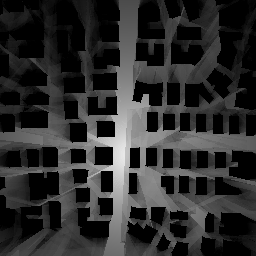

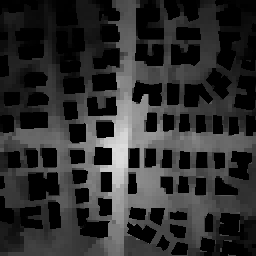

In [ ]:

data_shape = 256
_, _, img_target, _ = get_origin_data(pic_id, idx)

out = model(data.x, data.edge_index, data.edge_attr)

print(out)
res = np.int16(out.detach().numpy())
# print(res)

img_out = np.zeros([data_shape, data_shape], dtype=np.int16)

for n in range(data.num_nodes):
    i = int(data.mid[n][0])
    j = int(data.mid[n][1])
    if data.is_air[n]:
        img_out[i][j] = int(res[n])

img_out = Image.fromarray(img_out)
img_out = img_out.convert('L')


display(Image.fromarray(img_target))
display(img_out)